# Take a look of data

Many thanks for Radek's starter guide

https://github.com/radekosmulski/rsna-intracranial

In [1]:
# uncomment this line if don't have pydicom
#!pip install pydicom

In [8]:
%matplotlib inline

import PIL
import pydicom
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import fastai
from fastai.core import parallel

In [5]:
torch.__version__, fastai.__version__

('1.2.0', '1.0.58')

In [6]:
!pwd

/home/jupyter/rsns


In [2]:
path = Path('/home/jupyter/rsns/data/raw/')
path.ls()

[PosixPath('/home/jupyter/rsns/data/raw/stage_1_sample_submission.csv.zip'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train.csv.zip'),
 PosixPath('/home/jupyter/rsns/data/raw/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train.csv'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_images'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_sample_submission.csv'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_test_images'),
 PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_128.csv')]

In [3]:
#takes couple hours to finish
#!unzip -q -o {path}/rsna-intracranial-hemorrhage-detection.zip -d {path}

In [5]:
!ls {path}/stage_1_train_images | head -10

ID_000039fa0.dcm
ID_00005679d.dcm
ID_00008ce3c.dcm
ID_0000950d7.dcm
ID_0000aee4b.dcm
ID_0000f1657.dcm
ID_000178e76.dcm
ID_00019828f.dcm
ID_0001dcc25.dcm
ID_0001de0e8.dcm
ls: write error: Broken pipe


In [3]:
path = path/'stage_1_train_images'
files = path.ls()
len(files)

674257

In [10]:
one_file = files[0]
one_file

PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_images/ID_4c995fb13.dcm')

In [11]:
im = pydicom.read_file(str(one_file))

In [12]:
im

(0008, 0018) SOP Instance UID                    UI: ID_4c995fb13
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_7d3d32cf'
(0020, 000d) Study Instance UID                  UI: ID_2d49a3e4a3
(0020, 000e) Series Instance UID                 UI: ID_6a2dab02f4
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '3.02994322', '213.968705']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.956304756', '-0.292371705']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [17]:
im.keys()

dict_keys([(0008, 0018), (0008, 0060), (0010, 0020), (0020, 000d), (0020, 000e), (0020, 0010), (0020, 0032), (0020, 0037), (0028, 0002), (0028, 0004), (0028, 0010), (0028, 0011), (0028, 0030), (0028, 0100), (0028, 0101), (0028, 0102), (0028, 0103), (0028, 1050), (0028, 1051), (0028, 1052), (0028, 1053), (7fe0, 0010)])

In [20]:
im[('0028','1050')]

(0028, 1050) Window Center                       DS: ['00040', '00040']

In [21]:
im.WindowCenter

['00040', '00040']

In [4]:
def get_dicom_single_value(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

In [36]:

window_cnt,window_wid = [], []

for i in range(3000):
    im = pydicom.read_file(str(files[i]))
    window_cnt.append(get_dicom_single_value(im.WindowCenter))
    window_wid.append(get_dicom_single_value(im.WindowWidth))

print(np.mean(window_cnt),np.mean(window_wid))
print(np.std(window_cnt),np.std(window_wid))

36.13466666666667 95.57733333333333
19.622653529926975 120.00606381716253


# Gotchas...
Radek and some kagglers made assumption that center=40 and width=80 for window

However, as we can see, the mean of center and width are not 40 and 80. Also, width std is about 120... (from 3000 samples)

It might approximate to 40 and 80 if we run entire 670k data, however, I didn't see any advantages of setting fixed center / width

It is not safe to make this assumption, plus it takes almost 2 hours to preprocess data.

I will use window center and width from mega data to pre-process.

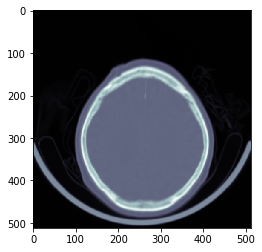

In [22]:
plt.imshow(im.pixel_array,cmap=plt.cm.bone)

In [24]:
im.pixel_array.shape

(512, 512)

# HC unit for CT scan

Based on Kaggle community discussion, radiologist use HC unit for CT images. Let's try using the window size suggested by radiologist


# Updated: 

window_normalize to dynamic getting meta data instead of fixing window size

return pixel value between 0-255

In [5]:
def window_and_normalize(im):
    window_center = get_dicom_single_value(im.WindowCenter)
    window_width = get_dicom_single_value(im.WindowWidth) // 2
    rescaled = im.pixel_array * float(im.RescaleSlope) + float(im.RescaleIntercept)
    windowed = rescaled.clip(min=window_center-window_width, max=window_center+window_width)
    return (windowed + np.negative(window_center-window_width)) / (window_width * 2 * 1/255)

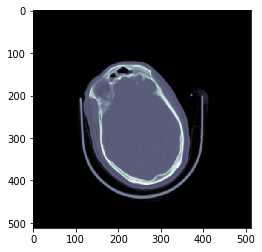

In [41]:
plt.imshow(im.pixel_array,cmap=plt.cm.bone)

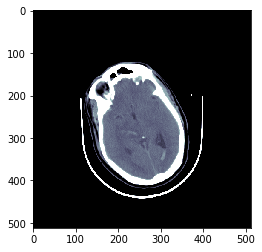

In [39]:
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

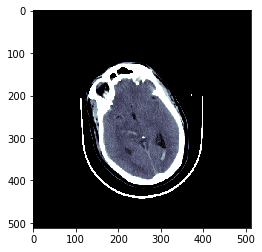

In [43]:
# width // 2
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

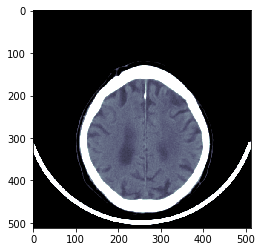

In [28]:
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

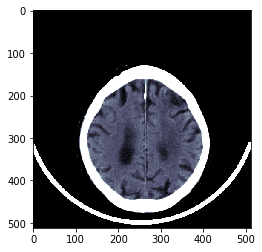

In [32]:
#suggested by radiologist
window_width = 80//2
plt.imshow(window_and_normalize(im),cmap=plt.cm.bone)

In [6]:
path

PosixPath('/home/jupyter/rsns/data/raw/stage_1_train_images')

In [59]:
!mkdir /home/jupyter/rsns/data/preprocessed/128
!mkdir /home/jupyter/rsns/data/preprocessed/128/train
!mkdir /home/jupyter/rsns/data/preprocessed/128/test

In [6]:
def resize(src, dst, sz):
    im = pydicom.read_file(str(src))
    ary = window_and_normalize(im)
    im = PIL.Image.fromarray(ary.astype(np.int8), mode='L')
    im.resize((sz,sz), resample=PIL.Image.BICUBIC).save(f'{dst}/{src.stem}.png')

In [61]:
def _resize_128(path,_):
    resize(path,'/home/jupyter/rsns/data/preprocessed/128/train',128)

In [62]:
parallel(_resize_128,path.ls(),max_workers=16)

# Check damaged file base on kaggle

[Kaggle_post](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109476#latest-629906)

In [3]:
one_file = path/'stage_1_train_images/ID_6431af929.dcm'

In [8]:
im = pydicom.read_file(str(one_file))

In [10]:
plt.imshow(im.pixel_array)

ValueError: The length of the pixel data in the dataset (153710 bytes) doesn't match the expected length (524288 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

In [11]:
!rm {one_file}

In [12]:
!ls {one_file}

ls: cannot access '/home/jupyter/rsns/data/raw/stage_1_train_images/ID_6431af929.dcm': No such file or directory


# Take a look after pre-processing

In [63]:
!ls /home/jupyter/rsns/data/preprocessed/128/train -l | wc -l

674258


In [64]:
path_train = Path('/home/jupyter/rsns/data/preprocessed/128/train')

In [65]:
one_file = path_train.ls()[0]

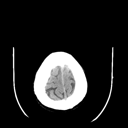

In [66]:
PIL.Image.open(one_file)

In [19]:
import pandas as pd

df = pd.read_csv('/home/jupyter/rsns/data/raw/stage_1_train.csv')
df.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [20]:
df[df['ID'].str.match('ID_6431af929')]

,ID,Label
3872988,ID_6431af929_epidural,0
3872989,ID_6431af929_intraparenchymal,0
3872990,ID_6431af929_intraventricular,0
3872991,ID_6431af929_subarachnoid,0
3872992,ID_6431af929_subdural,0
3872993,ID_6431af929_any,0


In [21]:
#drop it since we dropped the data in train set
df = df[~df['ID'].str.match('ID_6431af929')]

In [23]:
df.to_csv('/home/jupyter/rsns/data/raw/stage_1_train_128.csv',index=False)

In [67]:
path_test = Path('/home/jupyter/rsns/data/raw/stage_1_test_images/')
def _resize_test_128(path,_):
    resize(path,'/home/jupyter/rsns/data/preprocessed/128/test',128)

In [25]:
parallel(_resize_test_128,path_test.ls(),max_workers=16)

# Resize 224


In [7]:
!mkdir /home/jupyter/rsns/data/preprocessed/224
!mkdir /home/jupyter/rsns/data/preprocessed/224/train
!mkdir /home/jupyter/rsns/data/preprocessed/224/test

In [20]:
def _resize_224(path,_):
    resize(path,'/home/jupyter/rsns/data/preprocessed/224/train',224)

In [22]:
parallel(_resize_224,path.ls(),max_workers=8)

In [23]:
path_test = Path('/home/jupyter/rsns/data/raw/stage_1_test_images/')
def _resize_test_224(path,_):
    resize(path,'/home/jupyter/rsns/data/preprocessed/224/test',224)
parallel(_resize_test_224,path_test.ls(),max_workers=8)